In [1]:
import carla

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from time import sleep
from copy import deepcopy

%matplotlib inline

In [2]:
client = carla.Client("localhost", 2000)
client.set_timeout(10)

In [3]:
def load_map(reload_map: bool, map_name: str):
    if reload_map:
        world = client.load_world(map_name)
    else:
        world = client.get_world()

        # Spawn point
        origin = carla.Location(0.0, 0.0, 0.0)

        world.debug.draw_string(
            origin,
            "o",
            draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0),
            life_time=20.0,
            persistent_lines=False,
        )
    return world

In [4]:
map = "Town01"
save_dir = f"maps/{map}/"

stride = 64.0
z = 32.0

world =load_map(reload_map=True, map_name=map)

settings = world.get_settings()
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)

3779

In [5]:
spectator = world.get_spectator()

In [6]:
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=0.0, y=0.0, z=32.0), carla.Rotation(yaw=+00, pitch=-90))
camera_bp.set_attribute("image_size_x",str(512))
camera_bp.set_attribute("image_size_y",str(512))
camera_bp.set_attribute("fov",str(90))
camera = world.spawn_actor(camera_bp, camera_transform)

In [7]:
def get_image(data):
    global frame
    frame = data

def process_frame(frame, path):
    frame.convert(carla.ColorConverter.CityScapesPalette)
    raw = np.array(frame.raw_data).astype('uint8')
    bgra = np.reshape(raw, (512, 512, 4))
    bgra = Image.fromarray(bgra, 'RGBA')
    img = bgra.convert("RGB")
    img.save(path)
    return img

In [8]:
camera.listen(lambda data: get_image(data))

In [9]:
def get_mosaic(X, Y, save_dir):
    imgs = []
    for x in X:
        for y in Y:
            loc = carla.Location(x=x, y=y, z=z)
            camera.set_location(loc)
            spectator.set_transform(camera.get_transform())
            sleep(0.15)
            img_path = f"{save_dir}/{map}-{int(x)},{int(y)}.jpg"
            img = process_frame(frame, img_path)
            imgs.append(img)
    return imgs

def concat_mosaic(imgs, path='mosaic.jpg'):
    ab = np.concatenate((np.array(imgs[2]), np.array(imgs[3])), axis=1)
    cd = np.concatenate((np.array(imgs[0]), np.array(imgs[1])), axis=1)
    abcd = np.concatenate((ab, cd), axis=0)

    abcd.shape
    mosaic = Image.fromarray(abcd)
    mosaic.save(path)
    return abcd

def concat_mosaic_of_mosaics(imgs, path='mosaic.jpg'):
    ab = np.concatenate((np.array(imgs[2]), np.array(imgs[3])), axis=1)
    cd = np.concatenate((np.array(imgs[0]), np.array(imgs[1])), axis=1)
    abcd = np.concatenate((ab, cd), axis=0)

    abcd.shape
    mosaic = Image.fromarray(abcd)
    mosaic.save(path)
    return abcd

In [12]:
mosaics=[]

offsets = [(0.0, 0.0), (0.0, 128.0), (128.0, 0.0), (128.0, 128.0)]

for ox, oy in offsets:
    x_min, x_max = 0 + ox, 64.0 + ox
    y_min, y_max = 0 + oy, 64.0 + oy

    X = np.arange(x_min, x_max+stride, stride)
    Y = np.arange(y_min, y_max+stride, stride)

    imgs = get_mosaic(X, Y, save_dir)
    saico = concat_mosaic(imgs, "mosaic3.jpg")
    mosaics.append(saico)

mopsycho = concat_mosaic_of_mosaics(mosaics)

In [ ]:
map = "Town01"
save_dir = f"maps/{map}/"

stride = 64.0
z = 32.0

mosaics=[]
x_min, x_max = 0 + ox, 64.0 + ox
y_min, y_max = 0 + oy, 64.0 + oy

X = np.arange(x_min, x_max+stride, stride)
Y = np.arange(y_min, y_max+stride, stride)

imgs = get_mosaic(X, Y, save_dir)
saico = concat_mosaic(imgs, "mosaic3.jpg")


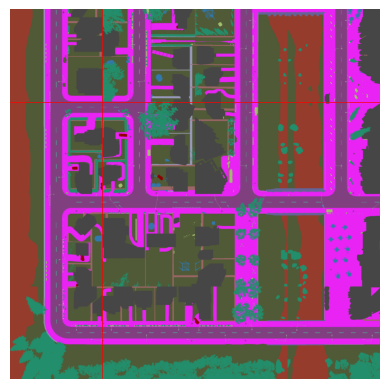

In [13]:
plt.imshow(mopsycho)
plt.grid(False)
plt.axis('off')
plt.axhline(y = 512, color = 'r', linewidth=0.5,linestyle = '-') 
plt.axvline(x = 512, color = 'r', linewidth=0.5, linestyle = '-') 
plt.savefig('mosaic-plt.png')
plt.show()


In [ ]:
import cv2
from pathlib import Path

from mosaic import VideMosaic

is_first_frame = True

for x in X:
    for y in Y:

        loc = carla.Location(x=x, y=y, z=z)
        camera.set_location(loc)
        img_path = f"{save_dir}/{map}-{int(x)},{int(y)}.jpg"
        img.save(img_path)

        if is_first_frame:
            video_mosaic = VideMosaic(np.array(img, dtype=np.uint8), detector_type="sift")
            is_first_frame = False
            continue
        

        # process each frame
        video_mosaic.process_frame(np.array(img, dtype=np.uint8))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('mosaic.jpg', video_mosaic.output_img)

